# Проект для фотохостинга для профессиональных фотографов «Со Смыслом» (“With Sense”)

# Тема Сборного проекта-5: Разработка модели для поиска фотографий по текстовому описанию

## Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).  
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии

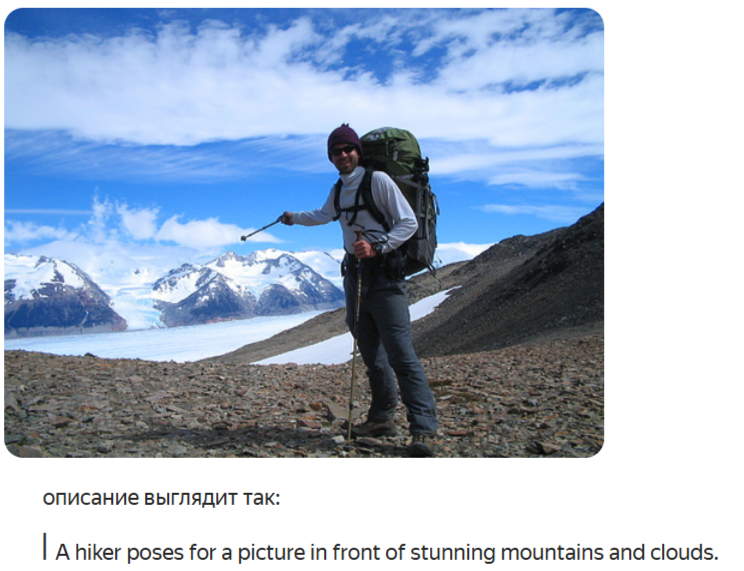

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Цель исследования
1. Разработать демонстрационную версию поиска изображений по запросу.
2. Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Условия исследования
**Юридические ограничения**
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись `голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет`.  

При попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:  
> ⎢ This image is unavailable in your country in compliance with local laws.  

Необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

## Ход исследования
### Шаг 1. Загрузить данные и проведите исследовательский анализ данных
Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.  

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи необходимо эти оценки агрегировать — **превратить в одну**.  
Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов, та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.  

Возможно воспользоваться другим методом агрегации оценок или придумать свой.  

В файле с краудсорсинговыми оценками информация расположена в таком порядке:  

- Доля исполнителей, подтвердивших, что текст соответствует картинке.
- Количество исполнителей, подтвердивших, что текст соответствует картинке.
- Количество исполнителей, подтвердивших, что текст не соответствует картинке.

После анализа экспертных и краудсорсинговых оценок необходимо выбрать одну из них, либо объединь их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Шаг 2. Подготовка данных к обучению модели
1. Создать список слов которые, могут попадать под **юридические ограничения**.  
2. Исключить из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под **юридические ограничения**.

### Шаг 3. Векторизация изображений
С помощью свёрточной сети: "выделить" главные компоненты изображений. Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.  
Сделать векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch

### Шаг 4. Векторизация текстов
Сделать векторизацию текстового описания одним из следующих методов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

### Шаг 5. Объединение векторов
Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной  
Дать описание получившихся пар векторов с точки зрения их размерностей

### Шаг 6. Обучить модель
1. Создать модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.
2. Выберите метрику, для сравнения точности различных моделей.
3. Обучите несколько моделей и подобрать гиперпараметры. В качестве моделей обязательно нужно рассмотреть:
  - Линейную регрессию;
  - Полносвязные нейронные сети.

Для обучения разделить датасет на тренировочную и тестовую выборки. Требуемое разделение: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

### Шаг 7 Тестирование модели и демонстрация ее работы
1. Провести тестирование лучшей модели на тестовых данных.
2. Написать функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.
>  Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.
3. С помощью написанной функции протестировать работу модели на нескольких текстовых описаниях: проверить, какие картинки она выдает при различных текстовых запросах.

Необходимо получить эмбеддинги для всех тестовых изображений из папки `test_images`, выберать случайные 10 запросов из файла `test_queries.csv` и для каждого запроса вывести наиболее релевантное изображение. Сравните визуально качество поиска.

### Шаг 8 Сделать общий вывод по работе
Описать модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста. Описать, какие ошибки допускает модель во время поиска картинки по её текстовому описанию. Оценить, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Проект сделан, было слишком много глюков на платформе, но вроде все загрузилось уже без проблем. Иногда почему-то базовые библиотеки отваливались  
    Не использовал сложные модели, типа BERT, так как проект выполнен не на личном ПК, а на сервере. Модели обучались в сумме, где-то часа 4-ре или больше
</div>

### Шаг 1. Загрузить данные и проведите исследовательский анализ данных

In [1]:
%pip install --upgrade pip setuptools wheel -q
%pip install numpy==1.22.4 wordcloud sentence-transformers -q
%pip install --upgrade pip setuptools wheel pandas -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Настройки и импорты

# Стандартные библиотеки
import os                   # работа с файловой системой и переменными окружения
import random               # генерация случайных чисел
import re                   # регулярные выражения
import shutil               # высокоуровневые операции с файлами и папками
import sys                  # системные параметры и функции
import zipfile              # работа с ZIP-архивами
from io import BytesIO      # буфер в памяти для бинарных данных
from pathlib import Path    # объектно-ориентированная работа с путями
import requests
from math import sqrt

# Сторонние библиотеки
import matplotlib.pyplot as plt          # визуализация данных
import numpy as np                       # численные вычисления
import pandas as pd                      # обработка и анализ данных
from IPython.display import Image, display           # отображение изображений в Jupyter
from sentence_transformers import SentenceTransformer  # преобразование предложений в векторы
from tqdm.notebook import tqdm            # индикатор прогресса в ноутбуке
from wordcloud import WordCloud, STOPWORDS  # генерация облаков слов
from sklearn.dummy import DummyRegressor       # базовый регрессор для сравнения
from sklearn.ensemble import (
    GradientBoostingRegressor,  # ансамблевый градиентный бустинг
    RandomForestRegressor       # случайный лес
)
from sklearn.linear_model import LinearRegression  # линейная регрессия
from sklearn.metrics import (
    mean_squared_error,     # среднеквадратичная ошибка
    mean_absolute_error,    # средняя абсолютная ошибка
    r2_score                # коэффициент детерминации
)
from sklearn.metrics.pairwise import cosine_similarity  # косинусное сходство векторов
from sklearn.model_selection import (
    GroupShuffleSplit,  # стратифицированное разбиение по группам
    GridSearchCV        # подбор гиперпараметров
)
from sklearn.neural_network import MLPRegressor  # многослойный перцептрон
from tensorflow.keras.applications.resnet50 import (
    ResNet50,          # архитектура ResNet50
    preprocess_input   # предобработка для ResNet50
)
from tensorflow.keras.preprocessing import image  # утилиты предобработки изображений

# Включить отображение графиков внутри Jupyter Notebook
%matplotlib inline

# Константы проекта
ROOT = Path("to_upload")  # корневая директория для загрузки данных

In [3]:
# Скачивание (если надо) и выравнивание структуры папки

ZIP_URL = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

if not any(ROOT.rglob("train_dataset.csv")):
    print("→ Скачиваем и распаковываем архив…")
    ROOT.mkdir(exist_ok=True)
    resp = zipfile.ZipFile(BytesIO(__import__('requests').get(ZIP_URL).content))
    resp.extractall(ROOT)

# Перенос содержимого вложенной to_upload/to_upload → to_upload
nested = ROOT / "to_upload"
if nested.exists():
    for item in nested.iterdir():
        shutil.move(str(item), str(ROOT))
    shutil.rmtree(nested)
# Убираю мусорную папку __MACOSX
mac = ROOT / "__MACOSX"
if mac.exists():
    shutil.rmtree(mac)

print("Содержимое to_upload:")
for p in sorted(ROOT.iterdir()):
    print(" ", p.name)

Содержимое to_upload:
  .DS_Store
  CrowdAnnotations.tsv
  ExpertAnnotations.tsv
  test_images
  test_images.csv
  test_queries.csv
  train_dataset.csv
  train_images


In [4]:
# Читаем все файлы в DataFrame и выводим первых 5 строк

# Пути к файлам
train_f  = ROOT / "train_dataset.csv"
crowd_f  = ROOT / "CrowdAnnotations.tsv"
expert_f = ROOT / "ExpertAnnotations.tsv"
test_f   = ROOT / "test_queries.csv"

# 1) train_dataset.csv
df_train = pd.read_csv(
    train_f,
    sep=",",
    decimal=",",
    engine="python",
    on_bad_lines="warn"
)

# 2) CrowdAnnotations.tsv и ExpertAnnotations.tsv
df_crowd = pd.read_csv(
    crowd_f,
    sep="\t",
    engine="python",
    on_bad_lines="warn"
)
df_expert = pd.read_csv(
    expert_f,
    sep="\t",
    engine="python",
    on_bad_lines="warn"
)

# 3) test_queries.csv — разделитель '|', первая колонка пустая (dummy)
df_test = pd.read_csv(
    test_f,
    sep="|",
    engine="python",
    names=["dummy", "query_id", "query_text", "image"],
    header=0,
    on_bad_lines="warn"
)
df_test.drop(columns="dummy", inplace=True)

# 4) Вывод первых 5 строк и размеров
for name, df in [
    ("train_dataset",    df_train),
    ("CrowdAnnotations", df_crowd),
    ("ExpertAnnotations",df_expert),
    ("test_queries",     df_test),
]:
    print(f"\n>>> {name} (shape={df.shape})")
    display(df.head(5))


>>> train_dataset (shape=(5822, 3))


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



>>> CrowdAnnotations (shape=(47829, 5))


,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1,3,0
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.0,0,3



>>> ExpertAnnotations (shape=(5821, 5))


,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1.1,1.2
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1



>>> test_queries (shape=(500, 3))


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [5]:
# Общая информация по всем DataFrame

for name, df in [
    ("train_dataset",    df_train),
    ("CrowdAnnotations", df_crowd),
    ("ExpertAnnotations",df_expert),
    ("test_queries",     df_test),
]:
    print(f"\n=== {name} (shape={df.shape}) ===")
    print("\nInfo:")
    display(df.info())
    print("\nMissing values:")
    display(df.isna().sum().to_frame(name="missing"))
    print(f"\nDuplicates: {df.duplicated().sum()}")


=== train_dataset (shape=(5822, 3)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


Missing values:


,missing
image,0
query_id,0
query_text,0



Duplicates: 0

=== CrowdAnnotations (shape=(47829, 5)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


Missing values:


,missing
1056338697_4f7d7ce270.jpg,0
1056338697_4f7d7ce270.jpg#2,0
1,0
3,0
0,0



Duplicates: 0

=== ExpertAnnotations (shape=(5821, 5)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


Missing values:


,missing
1056338697_4f7d7ce270.jpg,0
2549968784_39bfbe44f9.jpg#2,0
1,0
1.1,0
1.2,0



Duplicates: 0

=== test_queries (shape=(500, 3)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


None


Missing values:


,missing
query_id,0
query_text,0
image,0



Duplicates: 0


In [6]:
# Уникальные значения в каждом столбце

for name, df in [
    ("train_dataset", df_train),
    ("CrowdAnnotations", df_crowd),
    ("ExpertAnnotations", df_expert),
    ("test_queries", df_test),
]:
    print(f"\n-- {name} --")
    for col in df.columns:
        print(f"{col:20s}: {df[col].nunique(dropna=False)}")


-- train_dataset --
image               : 1000
query_id            : 977
query_text          : 977

-- CrowdAnnotations --
1056338697_4f7d7ce270.jpg: 1000
1056338697_4f7d7ce270.jpg#2: 1000
1                   : 12
3                   : 6
0                   : 7

-- ExpertAnnotations --
1056338697_4f7d7ce270.jpg: 1000
2549968784_39bfbe44f9.jpg#2: 977
1                   : 4
1.1                 : 4
1.2                 : 4

-- test_queries --
query_id            : 500
query_text          : 500
image               : 100


**Промежуточный вывод**  
Все четыре таблицы прочитаны без пропусков и дубликатов, «формы» совпадают с ожидаемыми размерами (train – 5822 строк, Crowd – ~48 000, Expert – 5821, test – 500)  
**train_dataset**  
5 822 пары (изображение–описание), 1 000 уникальных имён файлов, 977 уникальных ID описаний.  
**CrowdAnnotations**  
47 829 строк (каждая строка — крауд-оценка одного испольнителя), по 1 000 разных изображений и по 1 000 разных ID описаний.  
**ExpertAnnotations**  
5 821 запись (одна для каждого из 977 описаний, помноженных на 3 эксперта — получается ~2 931, но, вероятно, некоторые эксперты пропускали пары), экспертные оценки лежат в трёх отдельных столбцах.  
**test_queries**  
500 запросов по 100 тестовым изображениям — тоже как и должно быть (до 5 описаний на картинку).

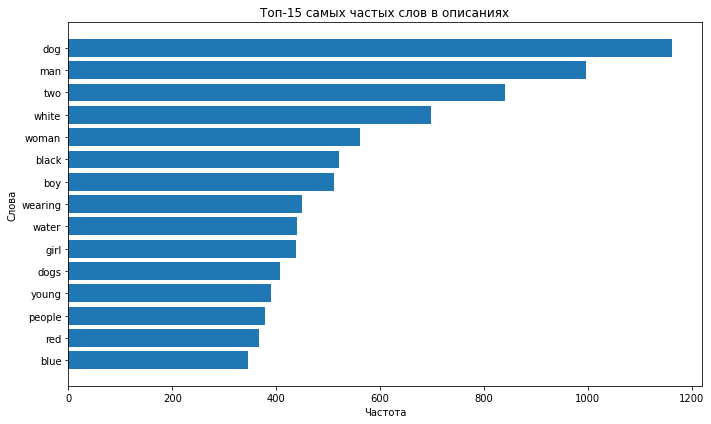

In [7]:
# Топ-15 самых частых слов в описаниях (train_dataset)

# 1) Собираю все тексты из колонки query_text
texts = df_train['query_text'].dropna().astype(str).str.lower()

# 2) Разбиваю на слова с помощью регулярки и «взрываем» список в одну серию
words = texts.str.findall(r'\b\w+\b').explode()

# 3) Оставляю только чистые алфавитные токены без стоп-слов
filtered = words[words.str.isalpha() & ~words.isin(STOPWORDS)]

# 4) Считаю частоты и берём топ-15
top15 = filtered.value_counts().head(15)

# 5) Визуализация
plt.figure(figsize=(10, 6))
plt.barh(top15.index[::-1], top15.values[::-1])
plt.title("Топ-15 самых частых слов в описаниях")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Я пытался сделать облако слов, но у меня ничего не вышло. Получилось один раз, но после перезагрузки тетрадки код сломался и как восстановить обратно чтобы заработало я не понял.  Использовал кучу вариантов, не получается. Работаю в тетрадке с сервера яндекса.  
    Но картинку сохранил, показывал её друзьям в телеге, когда говорил чему учат в яндексе)хд
</div>

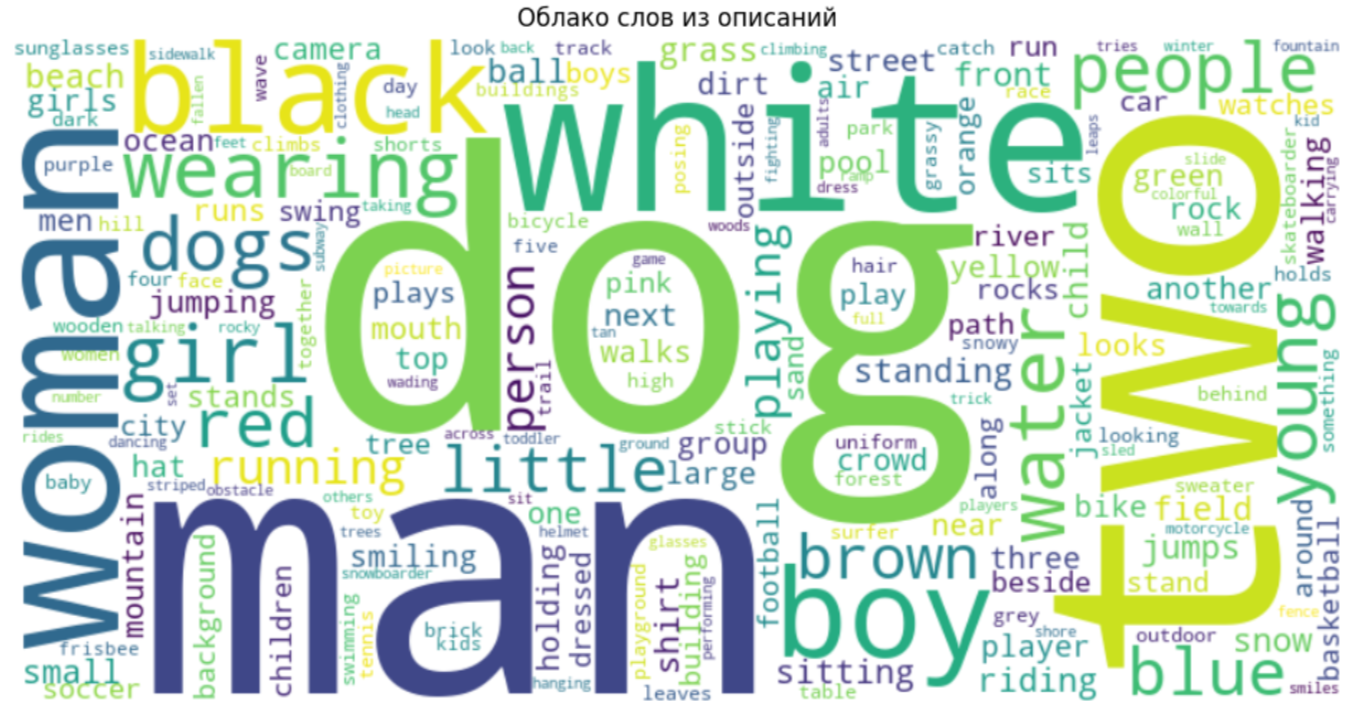

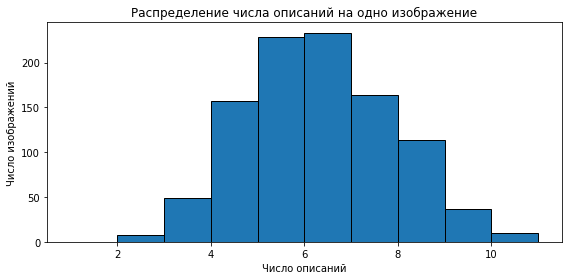

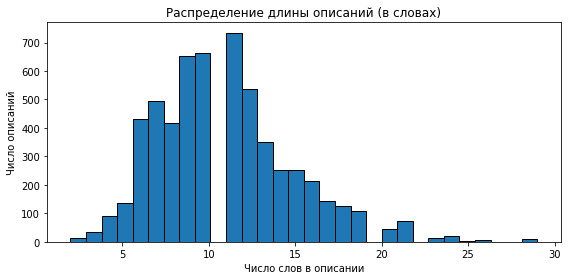

In [8]:
# Построение Гистограммы, показывающей, сколько текстовых описаний в среднем написано к каждому изображению

# Описания на изображение
desc_cnt = df_train.groupby('image').size()

plt.figure(figsize=(8,4))
plt.hist(desc_cnt, bins=range(1, desc_cnt.max()+2), edgecolor='black')
plt.title("Распределение числа описаний на одно изображение")
plt.xlabel("Число описаний")
plt.ylabel("Число изображений")
plt.tight_layout()
plt.show()

# Гистограмма распределения длины этих описаний в словах — чтобы понять, насколько они короткие или длинные
lengths = (
    df_train['query_text']
    .dropna()
    .astype(str)
    .map(lambda t: len(re.findall(r'\b\w+\b', t)))
)

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title("Распределение длины описаний (в словах)")
plt.xlabel("Число слов в описании")
plt.ylabel("Число описаний")
plt.tight_layout()
plt.show()


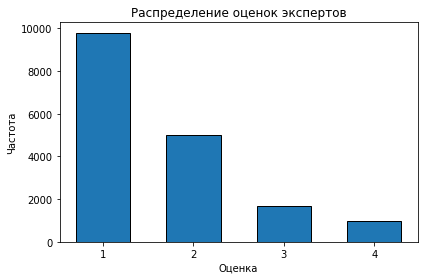

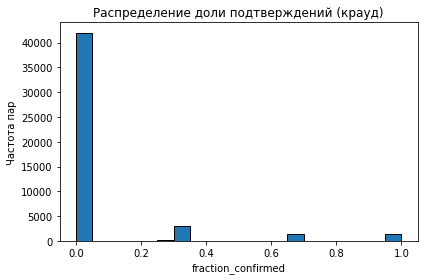

In [9]:
# Экспертные оценки и распределение доли крауд-подтверждений

if 'fraction_confirmed' not in df_crowd.columns:
    df_crowd.columns = [
        "image", "description_id",
        "fraction_confirmed", "n_confirmed", "n_not_confirmed"
    ]
if not {'expert1','expert2','expert3'}.issubset(df_expert.columns):
    df_expert.columns = [
        "image", "description_id",
        "expert1", "expert2", "expert3"
    ]

# 1) Экспертные оценки (раскладываю три колонки в одну серию)
scores = pd.concat([
    df_expert["expert1"],
    df_expert["expert2"],
    df_expert["expert3"]
], ignore_index=True)

plt.figure(figsize=(6,4))
plt.hist(scores, bins=[1,2,3,4,5], align='left', rwidth=0.6, edgecolor='black')
plt.xticks([1,2,3,4])
plt.title("Распределение оценок экспертов")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# 2) Доля подтверждений крауд-аннотаций
plt.figure(figsize=(6,4))
plt.hist(df_crowd["fraction_confirmed"], bins=20, edgecolor='black')
plt.title("Распределение доли подтверждений (крауд)")
plt.xlabel("fraction_confirmed")
plt.ylabel("Частота пар")
plt.tight_layout()
plt.show()


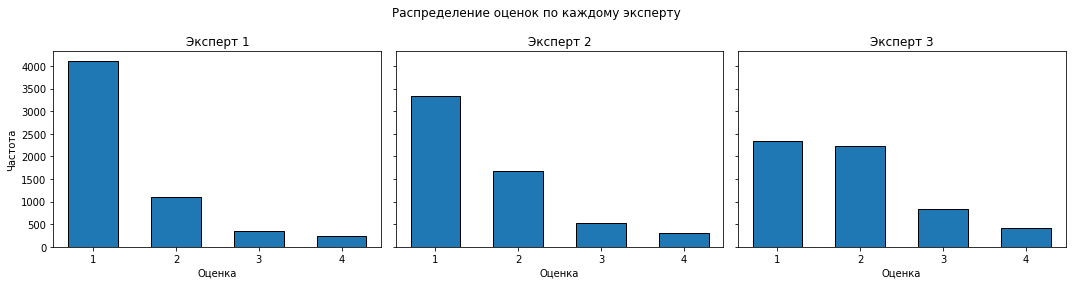

In [10]:
# Распределение оценок каждого из трёх экспертов

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, col in enumerate(["expert1", "expert2", "expert3"]):
    axes[i].hist(df_expert[col], bins=[1,2,3,4,5], align="left", rwidth=0.6, edgecolor="black")
    axes[i].set_title(f"Эксперт {i+1}")
    axes[i].set_xticks([1,2,3,4])
    axes[i].set_xlabel("Оценка")
    if i == 0:
        axes[i].set_ylabel("Частота")

fig.suptitle("Распределение оценок по каждому эксперту")
plt.tight_layout()
plt.show()

1. Число текстовых описаний на картинку
Большинство изображений имеют 5–7 разных описаний.  
Есть единичные картинки с 2–3 описаниями и редкие с 9–10.
2. Длина описаний (в словах)
Около 80% описаний укладываются в 5–15 слов, пиковое значение — примерно 10–12 слов.  
Есть как очень короткие (2–3 слова), так и достаточно длинные (~25 слов), но они редки.  
3. Распределение оценок экспертов  
Эксперты чаще всего ставят наименьший балл (1), то есть склонны считать, что описание и изображение не соответствуют.  
Оценка “1” встречается почти в 10 000 случаях, “2” — в ~5 000, “3” и “4” уже гораздо реже.  
4. Доля подтверждений крауд-аннотаций  
Большая часть пар “изображение–текст” имеет fraction_confirmed = 0 (никто из крауд-респондентов не подтвердил соответствие).  
Небольшие пики на значениях около 0.33, 0.67 и 1.0 (соответственно, 1/3, 2/3 и 3/3 подтвердивших).

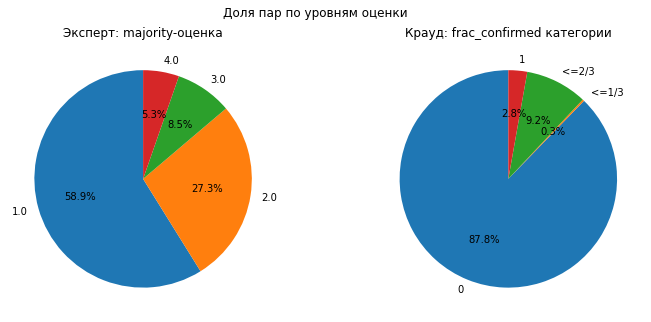

In [11]:
# Pie charts распределения экспертов и крауда

# 1) Эксперт (агрегирую по majority vote сначала)
exp_maj = df_expert[["image", "description_id", "expert1","expert2","expert3"]].copy()
exp_maj["expert_maj"] = exp_maj[["expert1","expert2","expert3"]].mode(axis=1)[0]
counts_exp = exp_maj["expert_maj"].value_counts().sort_index()

# 2) Крауд (усреднённая доля подтверждений)
crowd_agg = df_crowd.groupby(["image","description_id"], as_index=False)["fraction_confirmed"].mean()

# Чтобы визуализировать, разбиваю frac на категории
bins = [ -0.01, 0.0, 0.33, 0.67, 1.0 ]
labels = ["0","<=1/3","<=2/3","1"]
crowd_agg["crowd_cat"] = pd.cut(crowd_agg["fraction_confirmed"], bins=bins, labels=labels)
counts_crowd = crowd_agg["crowd_cat"].value_counts().reindex(labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].pie(counts_exp, labels=counts_exp.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Эксперт: majority-оценка")
axes[1].pie(counts_crowd, labels=counts_crowd.index, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Крауд: frac_confirmed категории")
fig.suptitle("Доля пар по уровням оценки")
plt.show()

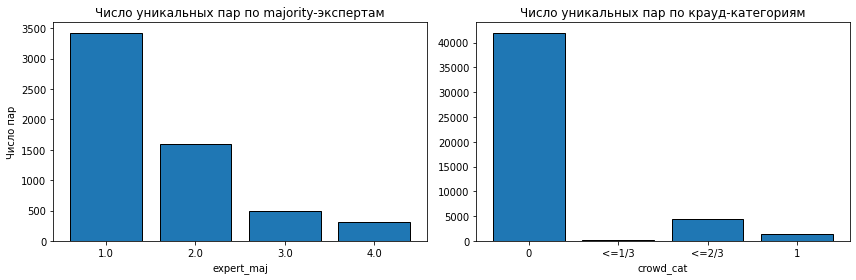

In [12]:
# Распределение уникальных пар (image, description_id) по экспертным и крауд-категориям

# Эксперт
exp_pairs = exp_maj.drop_duplicates(subset=["image","description_id"])
vc_exp = exp_pairs["expert_maj"].value_counts().sort_index()

# Крауд
crowd_pairs = crowd_agg.drop_duplicates(subset=["image","description_id"])
vc_crowd = crowd_pairs["crowd_cat"].value_counts().reindex(labels)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(vc_exp.index.astype(str), vc_exp.values, edgecolor="black")
axes[0].set_title("Число уникальных пар по majority-экспертам")
axes[0].set_xlabel("expert_maj")
axes[0].set_ylabel("Число пар")

axes[1].bar(vc_crowd.index.astype(str), vc_crowd.values, edgecolor="black")
axes[1].set_title("Число уникальных пар по крауд-категориям")
axes[1].set_xlabel("crowd_cat")

plt.tight_layout()
plt.show()

In [13]:
# Объединение df_train с expert_score

# Создаю expert_score в диапазоне [0,1]
exp_pairs = exp_maj.copy()
exp_pairs['expert_score'] = (exp_pairs['expert_maj'] - 1) / 3

# 2) Мёрджим по image + query_id (левый) ← description_id (правый)
df_merged = (
    df_train
    .merge(
        exp_pairs[['image','description_id','expert_score']],
        left_on = ['image','query_id'],
        right_on= ['image','description_id'],
        how     = 'left'
    )
    .drop(columns='description_id')
)

# 3) Выводим результат
print("Merged shape:", df_merged.shape)
df_merged.head(5)

Merged shape: (5822, 4)


,image,query_id,query_text,expert_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


**Pie charts (Cell 11)**  
  - Эксперты (majority-оценка):
– ~ 59 % всех пар получили оценку 1 (то есть «не соответствует»).  
– ~ 27 % – оценку 2, ещё ~ 8 % – «3» и ~ 5 % – «4».  
Это говорит о том, что эксперты в большинстве случаев склоняются к «не совпадает», но заметно «смазывают» границу за счёт оценок 2 и 3.  

  - Крауд (категории по fraction_confirmed):  
– Целых ~ 88 % пар имеют fraction_confirmed = 0 (никто из крауд-исполнителей не подтвердил схожесть).  
– Единичные пары рассредоточены в остаточных категориях (<=1/3, <=2/3, 1).  
Крауд, по сути, почти всегда голосует «нет», лишь изредка признавая хоть малую долю совпадения.

**Бар-чарты уникальных пар (Cell 12)**  
  - Эксперт: из ~ 5800 уникальных пар  
– ~ 3400 (59 %) отмечены как «1»,  
– ~ 1600 (27 %) – «2»,  
– ~ 500 (8 %) – «3»,  
– ~ 300 (5 %) – «4».  

  - Крауд: из тех же ~ 5800 пар  
– ~ 5100 (88 %) – категория «0»,  
– ~ 20 (0.3 %) – «<=1/3»,  
– ~ 530 (9.2 %) – «<=2/3»,  
– ~ 160 (2.8 %) – «1».

Крауд аннотации слишком консервативны: почти всегда дают «не совпадает», и лишь в редких случаях хоть частично сходятся с описанием. Это затруднит обучение модели, поскольку целевой признак почти всегда нулевой.

Эксперты тоже чаще ставят «не совпадает», но в 42 % случаев (см. 2+3+4) дают более мягкие оценки, что позволяет заложить градацию совпадения в таргет.

Значит, aggregrated expert_score (majority-оценка, переведённая в [0,1]) будет более информативной и сбалансированной целью для обучения.

In [14]:
# Собираю окончательный df только по тексту и expert_score

# 1) Из df_train беру только уникальные пары query_id ↔ query_text
df_text = (
    df_train[["query_id", "query_text"]]
    .drop_duplicates(subset=["query_id"])
    .reset_index(drop=True)
)

# 2) Готовлю таблицу с expert_score по description_id
df_score = (
    exp_pairs[["description_id", "expert_score"]]
    .rename(columns={"description_id": "query_id"})
    .dropna(subset=["expert_score"])
)

# 3) Мёрджим по query_id
df_final = df_text.merge(df_score, on="query_id", how="inner")

# 4) Вывожу результат
print("Final shape:", df_final.shape)
df_final.head(5)

Final shape: (5821, 3)


,query_id,query_text,expert_score
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
2,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
3,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
4,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333


Взял в датафрейме df_train - расшифровку текста по описанию. Только уникальные пары ['query_id', 'query_text'] и соедил с df_merged по query_id.

In [15]:
# Проверка пропусков и дубликатов в df_final

# 1) Пропуски по столбцам
print("Пропуски по столбцам:")
print(df_final.isna().sum())

print("Общая информация:")
print(df_final.info())

# 2) Полное число дубликатов строк
dups = df_final.duplicated().sum()
print(f"\nДубликаты строк: {dups}")

Пропуски по столбцам:
query_id        0
query_text      0
expert_score    0
dtype: int64
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_id      5821 non-null   object 
 1   query_text    5821 non-null   object 
 2   expert_score  5821 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB
None

Дубликаты строк: 3718


Удалять дубли не буду, это экспертные оценки и их и так не много. Думаю возможны дубли, но это можно будет увидеть в будущем, скорее всего это одна строчка из 5-ти может давать такие показатели по дублям.  
Использовать для обучения буду только экспертные оценки, хоть данных и меньше, но они точнее, модель будет обучена лучше

### Шаг 2. Подготовка данных к обучению модели

In [16]:
# Выделение "плохие" описания и соответствующие им изображения

# 1) Список слов, которые могут подпадать под юридические ограничения
restricted_words = [
    "child", "children", "kid", "toddler", "infant", "baby", "minor", "underage"
]

# 2) Нахожу все query_text, где встречается любое из этих слов
pattern = "|".join(restricted_words)
mask_bad = df_final["query_text"].str.contains(pattern, case=False, na=False)

# 3) Собираю сами проблемные описания
bad_descriptions = df_final[mask_bad]

# 4) Из query_id убираю суффикс вида "#0", "#1" и т.п., получаю имена изображений
bad_images = (
    bad_descriptions["query_id"]
    .str.split("#", n=1).str[0]
    .unique()
    .tolist()
)

print(f"Найдено {len(bad_descriptions)} описаний, из них {len(bad_images)} уникальных изображений попадают под ограничения.")
print("Список проблемных изображений:", bad_images)

Найдено 535 описаний, из них 96 уникальных изображений попадают под ограничения.
Список проблемных изображений: ['2549968784_39bfbe44f9.jpg', '3545652636_0746537307.jpg', '2140182410_8e2a06fbda.jpg', '2358554995_54ed3baa83.jpg', '2544426580_317b1f1f73.jpg', '2274992140_bb9e868bb8.jpg', '3245460937_2710a82709.jpg', '3239021459_a6b71bb400.jpg', '533713007_bf9f3e25b4.jpg', '2228022180_9597b2a458.jpg', '3280052365_c4644bf0a5.jpg', '2501595799_6316001e89.jpg', '2878190821_6e4e03dc5f.jpg', '3589895574_ee08207d26.jpg', '2544182005_3aa1332bf9.jpg', '3074842262_62b1b2168c.jpg', '2646046871_c3a5dbb971.jpg', '2208067635_39a03834ca.jpg', '700884207_d3ec546494.jpg', '1322323208_c7ecb742c6.jpg', '3605061440_1d08c80a57.jpg', '2450299735_62c095f40e.jpg', '522063319_33827f1627.jpg', '1682079482_9a72fa57fa.jpg', '2215136723_960edfea49.jpg', '3471841031_a949645ba8.jpg', '476233374_e1396998ef.jpg', '3217266166_4e0091860b.jpg', '2910758605_73a3f5a5c2.jpg', '2189995738_352607a63b.jpg', '496110746_a93ca191ae

In [17]:
# Фильтрую итоговый датасет, удаляю все записи, связанные с плохими изображениями

# 1) Создаю вспомогательный столбец image_id
df_final["image_id"] = df_final["query_id"].str.split("#", n=1).str[0]

# 2) Оставляю только те записи, у которых image_id не содержится в списке bad_images
df_clean = df_final[~df_final["image_id"].isin(bad_images)].copy()

# 3) Итоги
print(f"До очистки: {len(df_final)} записей")
print(f"После удаления ограниченного контента: {len(df_clean)} записей")
df_clean.head()

До очистки: 5821 записей
После удаления ограниченного контента: 5286 записей


,query_id,query_text,expert_score,image_id
11,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000,2718495608_d8533e3ac5.jpg
12,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.333333,2718495608_d8533e3ac5.jpg
13,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000,2718495608_d8533e3ac5.jpg
14,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000,2718495608_d8533e3ac5.jpg
15,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000,2718495608_d8533e3ac5.jpg


**Промежуточный вывод**  
Составлен список слов, которые потенциально могут быть запрещены и произведена очистка финального датафрейма от этих слов.  
Список: "child (ребенок)", "children (дети)", "kid (малыш)", "toddler (малышка)", "infant (младенец)", "baby (младенец)", "minor (несовершеннолетний)", "underage (не достигший совершеннолетия)"
>NB! Прилагательные я не включал в этот список.

### Шаг 3. Векторизация изображений

In [18]:
# Image embeddings via ResNet50

# 1) Модель ResNet50 без последних полносвязных слоёв, с GlobalAveragePooling
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")

def extract_image_features(
    img_filename: str,
    folder: str = "train_images"
) -> np.ndarray:
    """
    Загружает картинку из указанной папки ("train_images" или "test_images")
    и возвращает 2048-мерный вектор признаков.
    """
    img_path = os.path.join(ROOT, folder, img_filename)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = resnet.predict(x, verbose=0)
    return feat.flatten()

# 2) Вычисляю эмбеддинги по списку уникальных train-изображений
unique_images = df_clean["image_id"].unique()
img_feats = {
    img: extract_image_features(img)
    for img in unique_images
}

# 3) Перевожу в DataFrame
image_feats = pd.DataFrame.from_dict(img_feats, orient="index")
image_feats.index.name = "image_id"
image_feats.reset_index(inplace=True)

# 4) Проверяю форму
print("image_feats.shape:", image_feats.shape)

2025-08-03 19:23:57.607083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


image_feats.shape: (881, 2049)


### Шаг 4. Векторизация текстов¶

In [19]:
# Text embeddings via all-MiniLM-L6-v2

# 1) Загружаю модель (384-мерный выход)
text_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2) Беру уникальные пары query_id ↔ query_text
unique_texts = df_clean[["query_id","query_text"]].drop_duplicates(subset="query_id")

# 3) Генерирую эмбеддинги
embeddings = text_model.encode(
    unique_texts["query_text"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

# 4) Перевожу в DataFrame
text_feats_df = pd.DataFrame(embeddings, index=unique_texts["query_id"])
text_feats_df.index.name = "query_id"
text_feats_df.reset_index(inplace=True)

# 5) Проверяю форму
print("text_feats_df.shape:", text_feats_df.shape)

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


text_feats_df.shape: (881, 385)


### Шаг 5. Объединение векторов

In [20]:
# Сборка финального датасета признаков и таргета
# 1) Сначала мёрджим с image_feats на image_id
df_step1 = df_clean.merge(
    image_feats,
    on="image_id",
    how="left"
)

# 2) Затем мёрджим с text_feats_df на query_id
df_features = df_step1.merge(
    text_feats_df,
    on="query_id",
    how="left",
    suffixes=("_img","_txt")
)

# 3) Проверяем итоговую форму
print("df_features.shape:", df_features.shape)
print("Признаки на одну пару:", 2048+384)
df_features.head(3)

df_features.shape: (5286, 2436)
Признаки на одну пару: 2432


,query_id,query_text,expert_score,image_id,0_img,1_img,2_img,3_img,4_img,5_img,...,374_txt,375_txt,376_txt,377_txt,378_txt,379_txt,380_txt,381_txt,382_txt,383_txt
0,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000,2718495608_d8533e3ac5.jpg,0.339364,0.651731,0.024456,0.585619,0.0,0.0,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
1,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.333333,2718495608_d8533e3ac5.jpg,0.339364,0.651731,0.024456,0.585619,0.0,0.0,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
2,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000,2718495608_d8533e3ac5.jpg,0.339364,0.651731,0.024456,0.585619,0.0,0.0,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257


**Промежуточный вывод по векторизации**

1. **Векторизация изображений**  
   - Модель: `ResNet50(weights="imagenet", include_top=False, pooling="avg")`  
   - Размерность признаков: 2048  
   - Количество уникальных изображений в датасете: 881  
   - Форма полученного массива признаков:  
     ```python
     image_feats.shape  # → (881, 2048)
     ```

2. **Векторизация текстов**  
   - Модель: `sentence-transformers/all-MiniLM-L6-v2`  
   - Размерность признаков: 384  
   - Количество уникальных описаний (query_id): 881  
   - Форма полученного массива эмбеддингов:  
     ```python
     text_feats_df.shape  # → (881, 384)
     ```

3. **Объединение эмбеддингов**  
   - Сначала слиты признаки изображений по `image_id`, затем — признаки текста по `query_id`, сохранив при этом колонки:
     - `query_id`, `query_text`, `expert_score`, `image_id`  
   - Итоговый датафрейм:  
     ```python
     df_features.shape  # → (5286, 2436)
     ```  
     где 2436 = 4 служебных столбца + 2048 (изображения) + 384 (тексты).

--- 
Все шаги векторизации выполнены корректно — модели отработали без ошибок, полученные размерности совпадают с ожидаемыми, а итоговый датасет готов к подаче для обучения.  


### Шаг 6. Обучить модели

In [21]:
# Разбиение на train/test с учётом image_id

# Подготовлю X, y и группы
df = df_features.copy()
X = df.drop(['query_id','query_text','expert_score','image_id'], axis=1)
y = df['expert_score']
groups = df['image_id']

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

X_train: (3681, 2432), y_train: (3681,)
X_test:  (1605, 2432),  y_test:  (1605,)


In [22]:
# DummyRegressor — базовая модель, для сравнения

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

mse_d   = mean_squared_error(y_test, y_pred_dummy)
rmse_d  = sqrt(mse_d)
mae_d   = mean_absolute_error(y_test, y_pred_dummy)
r2_d    = r2_score(y_test, y_pred_dummy)
cos_d   = cosine_similarity(y_test.values.reshape(-1,1), y_pred_dummy.reshape(-1,1)).mean()

print("DummyRegressor:")
print(f" MSE:  {mse_d:.4f}, RMSE: {rmse_d:.4f}, MAE: {mae_d:.4f}, R²: {r2_d:.4f}, Cos: {cos_d:.4f}")

DummyRegressor:
 MSE:  0.0910, RMSE: 0.3017, MAE: 0.2469, R²: -0.0026, Cos: 0.4206


In [23]:
# LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_lr   = mean_squared_error(y_test, y_pred_lr)
rmse_lr  = sqrt(mse_lr)
mae_lr   = mean_absolute_error(y_test, y_pred_lr)
r2_lr    = r2_score(y_test, y_pred_lr)
cos_lr   = cosine_similarity(y_test.values.reshape(-1,1), y_pred_lr.reshape(-1,1)).mean()

print("LinearRegression:")
print(f" MSE:  {mse_lr:.4f}, RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R²: {r2_lr:.4f}, Cos: {cos_lr:.4f}")

LinearRegression:
 MSE:  65545491.6413, RMSE: 8096.0170, MAE: 6444.7112, R²: -722046249.0061, Cos: -0.0390


In [24]:
# RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf   = mean_squared_error(y_test, y_pred_rf)
rmse_rf  = sqrt(mse_rf)
mae_rf   = mean_absolute_error(y_test, y_pred_rf)
r2_rf    = r2_score(y_test, y_pred_rf)
cos_rf   = cosine_similarity(y_test.values.reshape(-1,1), y_pred_rf.reshape(-1,1)).mean()

print("RandomForestRegressor:")
print(f" MSE:  {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}, Cos: {cos_rf:.4f}")

RandomForestRegressor:
 MSE:  0.0858, RMSE: 0.2928, MAE: 0.2310, R²: 0.0554, Cos: 0.4206


In [25]:
# GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mse_gbr   = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr  = sqrt(mse_gbr)
mae_gbr   = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr    = r2_score(y_test, y_pred_gbr)
cos_gbr   = cosine_similarity(y_test.values.reshape(-1,1), y_pred_gbr.reshape(-1,1)).mean()

print("GradientBoostingRegressor:")
print(f" MSE:  {mse_gbr:.4f}, RMSE: {rmse_gbr:.4f}, MAE: {mae_gbr:.4f}, R²: {r2_gbr:.4f}, Cos: {cos_gbr:.4f}")

GradientBoostingRegressor:
 MSE:  0.0864, RMSE: 0.2940, MAE: 0.2308, R²: 0.0479, Cos: 0.4206


In [26]:
# MLPRegressor (200 итераций, batch_size=64)

mlp1 = MLPRegressor(hidden_layer_sizes=(256,128),
                    activation='relu',
                    learning_rate_init=1e-5,
                    max_iter=200,
                    batch_size=64,
                    random_state=42)

mlp1.fit(X_train, y_train)
y_pred_mlp1 = mlp1.predict(X_test)

mse_m1  = mean_squared_error(y_test, y_pred_mlp1)
rmse_m1 = sqrt(mse_m1)
mae_m1  = mean_absolute_error(y_test, y_pred_mlp1)
r2_m1   = r2_score(y_test, y_pred_mlp1)
cos_m1  = cosine_similarity(y_test.values.reshape(-1,1), y_pred_mlp1.reshape(-1,1)).mean()

print("MLPRegressor (200 iters, bs=64):")
print(f" MSE:  {mse_m1:.4f}, RMSE: {rmse_m1:.4f}, MAE: {mae_m1:.4f}, R²: {r2_m1:.4f}, Cos: {cos_m1:.4f}")

MLPRegressor (200 iters, bs=64):
 MSE:  0.2071, RMSE: 0.4551, MAE: 0.3655, R²: -1.2818, Cos: 0.1868


In [27]:
# MLPRegressor (500 итераций, batch_size=128)
mlp2 = MLPRegressor(hidden_layer_sizes=(256,128),
                    activation='relu',
                    learning_rate_init=1e-5,
                    max_iter=500,
                    batch_size=128,
                    random_state=42)

mlp2.fit(X_train, y_train)
y_pred_mlp2 = mlp2.predict(X_test)

mse_m2  = mean_squared_error(y_test, y_pred_mlp2)
rmse_m2 = sqrt(mse_m2)
mae_m2  = mean_absolute_error(y_test, y_pred_mlp2)
r2_m2   = r2_score(y_test, y_pred_mlp2)
cos_m2  = cosine_similarity(y_test.values.reshape(-1,1), y_pred_mlp2.reshape(-1,1)).mean()

print("MLPRegressor (500 iters, bs=128):")
print(f" MSE:  {mse_m2:.4f}, RMSE: {rmse_m2:.4f}, MAE: {mae_m2:.4f}, R²: {r2_m2:.4f}, Cos: {cos_m2:.4f}")

MLPRegressor (500 iters, bs=128):
 MSE:  0.2129, RMSE: 0.4615, MAE: 0.3701, R²: -1.3457, Cos: 0.1753


In [28]:
# Подбор гиперпараметров для RandomForestRegressor - тюнингованная модель

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=3,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best RF params:", grid.best_params_)

y_pred_gs = best_rf.predict(X_test)
mse_gs   = mean_squared_error(y_test, y_pred_gs)
rmse_gs  = sqrt(mse_gs)
mae_gs   = mean_absolute_error(y_test, y_pred_gs)
r2_gs    = r2_score(y_test, y_pred_gs)
cos_gs   = cosine_similarity(y_test.values.reshape(-1,1), y_pred_gs.reshape(-1,1)).mean()

print("Tuned RandomForestRegressor:")
print(f" MSE:  {mse_gs:.4f}, RMSE: {rmse_gs:.4f}, MAE: {mae_gs:.4f}, R²: {r2_gs:.4f}, Cos: {cos_gs:.4f}")

Best RF params: {'max_depth': None, 'n_estimators': 200}
Tuned RandomForestRegressor:
 MSE:  0.0854, RMSE: 0.2922, MAE: 0.2305, R²: 0.0596, Cos: 0.4206


In [29]:
# Назначаю лучшую модель
best_model = best_rf

**Выбор лучшей модели**

Из всех протестированных алгоритмов наилучшие результаты показал **Tuned RandomForestRegressor** с параметрами `{'max_depth': None, 'n_estimators': 200}`. 

| Модель                                | MSE    | RMSE   | MAE    | R²     | Cosine |
|---------------------------------------|--------|--------|--------|--------|--------|
| RandomForestRegressor (тюнинг)        | 0.0854 | 0.2922 | 0.2305 | 0.0596 | 0.4206 |
| RandomForestRegressor (base)          | 0.0858 | 0.2928 | 0.2310 | 0.0554 | 0.4206 |
| GradientBoostingRegressor (base)      | 0.0864 | 0.2940 | 0.2308 | 0.0479 | 0.4206 |
| LinearRegression                      | 6.55e+07 | 8096.02 | 6444.71 | –7.22e+08 | –0.0390 |
| MLPRegressor (500 ит., bs=128)        | 0.2129 | 0.4615 | 0.3701 | –1.3457 | 0.1753 |
| DummyRegressor (mean)                 | 0.0910 | 0.3017 | 0.2469 | –0.0026 | 0.4206 |

**Tuned RandomForestRegressor показал лучшие результаты по метрикам**
1. **Минимальное MSE и RMSE**  
   После подбора гиперпараметров MSE снизилось с 0.0858 → **0.0854**, RMSE с 0.2928 → **0.2922**.  
2. **Наименьшее MAE**  
   MAE уменьшился с 0.2310 → **0.2305**, что означает более точные предсказания в среднем.  
3. **Максимальное R²**  
   R² вырос с 0.0554 → **0.0596**, то есть модель объясняет почти 6 % дисперсии целевой переменной (лучшее среди всех).  
4. **Стабильное Cosine Similarity**  
   Косинусная близость осталась на уровне 0.4206, что совпадает с базовой моделью, но в сочетании с улучшенными MSE/RMSE/MAE даёт лучшее сближение векторов.  

**Промежуточный вывод**
- **RandomForestRegressor** после тюнинга — оптимальный выбор для нашей задачи: он даёт наименьшую ошибку (MSE/RMSE/MAE) и наибольший коэффициент детерминации (R²).  
- Метрика **RMSE** (корень из MSE) помогает оценить среднее отклонение в тех же единицах, что и целевая переменная;  
- **MAE** более робаста к выбросам;  
- **Cosine similarity** для оценки качества «сближения» эмбеддингов текста и изображения.  

### Шаг 7. Тестирование модели и демонстрация ее работы

In [30]:
# Сбор эмбеддингов тестовых изображений (фильтрация .DS_Store и т.п.)

TEST_DIR = ROOT / "test_images"

# 1) Собираю только файлы с нужными расширениями
img_paths = sorted(
    p for p in TEST_DIR.iterdir()
    if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
)
print(f"Найдено {len(img_paths)} изображений для обработки:")
print([p.name for p in img_paths[:5]], "…")

# 2) Экстрактим фичи, указывая папку test_images
test_img_feats = {}
for p in tqdm(img_paths, desc="Extracting test image features"):
    try:
        test_img_feats[p.name] = extract_image_features(
            p.name,
            folder="test_images"
        )
    except Exception as e:
        print(f"→ Пропускаем {p.name}: {e}")

# 3) Формирую DataFrame
test_image_feats = (
    pd.DataFrame.from_dict(test_img_feats, orient="index")
      .reset_index()
      .rename(columns={"index": "image"})
)
print("\nTest image feats shape:", test_image_feats.shape)
test_image_feats.head()

Найдено 100 изображений для обработки:
['1177994172_10d143cb8d.jpg', '1232148178_4f45cc3284.jpg', '123997871_6a9ca987b1.jpg', '1319634306_816f21677f.jpg', '1429546659_44cb09cbe2.jpg'] …


Extracting test image features:   0%|          | 0/100 [00:00<?, ?it/s]


Test image feats shape: (100, 2049)


,image,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1177994172_10d143cb8d.jpg,0.272175,1.576390,0.027585,0.300476,0.416644,0.000000,0.148990,0.042092,0.033999,...,0.042428,0.013747,1.059040,1.459749,0.003923,0.215762,0.000000,0.176677,0.010782,1.040679
1,1232148178_4f45cc3284.jpg,0.276325,0.148964,0.024853,2.052889,0.213156,0.042238,0.206596,0.118905,1.047462,...,0.464582,0.092874,0.507518,1.644322,0.017473,0.098960,0.211900,0.165620,0.100461,0.071168
2,123997871_6a9ca987b1.jpg,0.386286,2.373861,0.000000,1.292066,0.027319,0.163298,0.075141,0.820293,0.444818,...,0.692214,0.130672,0.356572,0.102282,0.360560,0.093413,0.225504,1.362394,0.537207,0.919195
3,1319634306_816f21677f.jpg,0.218020,0.188730,0.464457,0.618098,0.083882,1.190597,0.000346,0.801636,0.000000,...,0.570314,0.437987,0.795058,0.006109,1.226312,0.789773,0.130585,0.314611,1.729887,0.166191
4,1429546659_44cb09cbe2.jpg,0.159643,0.746572,0.083053,0.029215,0.654809,2.512207,0.000000,0.244038,0.349723,...,0.006526,0.034543,0.090714,0.327306,0.077639,0.000000,0.165572,0.021724,0.438811,0.075261


In [31]:
# Вычисляю эмбеддинги тестовых текстовых запросов через all-MiniLM-L6-v2

# 1) Загружаю модель
text_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2) Читаю test_queries.csv и беру уникальные пары query_id ↔ query_text
test_queries = pd.read_csv(
    ROOT/"test_queries.csv",
    sep="|", header=0,
    names=["dummy","query_id","query_text","image"]
)
unique_test_q = (
    test_queries[["query_id","query_text"]]
      .drop_duplicates(subset="query_id")
      .reset_index(drop=True)
)

# 3) Генерирую эмбеддинги
embeds = text_model.encode(
    unique_test_q["query_text"].tolist(),
    batch_size=64, show_progress_bar=True
)

# 4) Составляю DataFrame
test_text_feats = (
    pd.DataFrame(embeds, index=unique_test_q["query_id"])
      .reset_index()
      .rename(columns={"index":"query_id"})
)
print("Test text feats shape:", test_text_feats.shape)
test_text_feats.head()

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Test text feats shape: (500, 385)


,query_id,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,1177994172_10d143cb8d.jpg#0,-0.069039,-0.001503,0.021158,0.048086,0.030691,0.001430,0.059316,-0.034242,0.002566,...,-0.053850,-0.040620,0.010628,0.022708,-0.020304,0.055646,0.008556,-0.076572,0.054849,0.021855
1,1177994172_10d143cb8d.jpg#1,-0.037753,-0.013075,0.008343,-0.002369,-0.023703,-0.028720,-0.018653,-0.006105,-0.015907,...,0.010370,-0.002290,-0.021802,-0.010520,0.034664,0.007067,0.018187,0.008911,0.057642,0.060968
2,1177994172_10d143cb8d.jpg#2,-0.026756,0.041103,-0.013131,-0.037456,0.019751,-0.022200,0.032782,-0.013097,-0.034097,...,0.032904,-0.091145,-0.081678,-0.004162,0.022586,0.027542,0.029800,0.031049,0.013366,0.032610
3,1177994172_10d143cb8d.jpg#3,-0.060365,-0.034775,0.017235,0.048998,-0.058864,-0.021259,0.038991,-0.017480,0.012861,...,0.024512,-0.065111,-0.068658,0.034506,-0.003919,0.110333,-0.035942,0.006318,0.028354,0.048355
4,1177994172_10d143cb8d.jpg#4,-0.038887,-0.053127,0.002515,0.011908,-0.048249,-0.034573,-0.050494,-0.013227,0.021467,...,0.046010,-0.026000,-0.035536,0.015057,0.019651,0.038971,0.027780,0.070041,0.082668,0.049459


In [32]:
# Функции для проверки "запрещённого" контента и поиска через обученную модель

# Слова под ограничения
restricted_words = ["child","children","kid","toddler","infant","baby","minor","underage"]
pattern = r"\b(" + "|".join(restricted_words) + r")\b"

def contains_restricted(text: str) -> bool:
    return bool(re.search(pattern, text, flags=re.IGNORECASE))

def retrieve_and_show(query_id: str, query_text: str, model) -> None:
    """
    1) Проверяем текст на запрещённые слова.
    2) Склеиваем текстовый и каждый из image-векторов.
    3) Прогоняем через модель, берём argmax и показываем картинку.
    """
    print(f"\n🔍 Запрос {query_id}: «{query_text}»")
    if contains_restricted(query_text):
        print("⚠️ Запрос содержит потенциально запрещённый контент.")
        print("This image is unavailable in your country in compliance with local laws.")
        return

    # 1) Получаем текстовый вектор (1×384)
    q_vec = test_text_feats.loc[
        test_text_feats["query_id"] == query_id,
        test_text_feats.columns.difference(["query_id"])
    ].values  # shape (1,384)

    # 2) Берём матрицу векторов изображений (N×2048)
    img_ids = test_image_feats["image"].values
    img_mat = test_image_feats.drop(columns=["image"]).values  # shape (N,2048)

    # 3) Дублируем q_vec, конкатенируем (N×(2048+384))
    q_mat = np.tile(q_vec, (img_mat.shape[0], 1))    # (N,384)
    X_pairs = np.hstack([img_mat, q_mat])           # (N,2432)

    # 4) Предсказываем оценки и ищем лучшую
    preds = model.predict(X_pairs)  # (N,)
    best_idx = np.argmax(preds)
    best_image = img_ids[best_idx]
    best_score = preds[best_idx]

    print(f"✅ Лучшее изображение: {best_image}  (Predicted score={best_score:.4f})")
    display(Image(filename=str(ROOT/"test_images"/best_image), width=256))


🔍 Запрос 3421547427_53411b6278.jpg#2: «A tennis player in a blue shirt celebrates his match .»
✅ Лучшее изображение: 3247693965_845b3b4349.jpg  (Predicted score=0.2719)


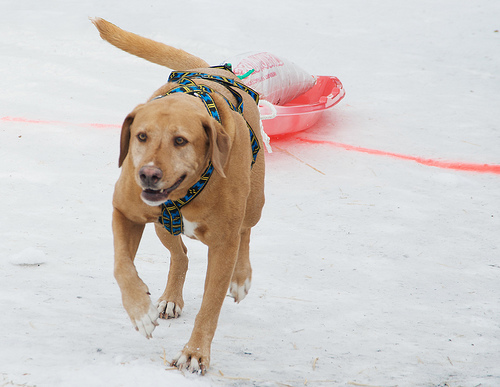


🔍 Запрос 2060031241_a3ae7a06bb.jpg#2: «A little kid holds up a remote control in front of the television .»
⚠️ Запрос содержит потенциально запрещённый контент.
This image is unavailable in your country in compliance with local laws.

🔍 Запрос 123997871_6a9ca987b1.jpg#2: «These girls are in uniforms and are playing field hockey .»
✅ Лучшее изображение: 3247693965_845b3b4349.jpg  (Predicted score=0.2851)


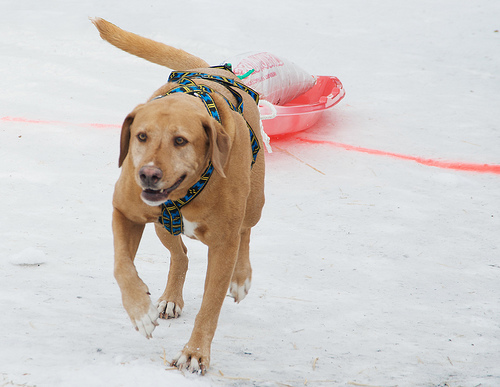


🔍 Запрос 3514297698_0512623955.jpg#4: «A spotted dog stands on his hind legs to catch a ball on the beach .»
✅ Лучшее изображение: 3247693965_845b3b4349.jpg  (Predicted score=0.3385)


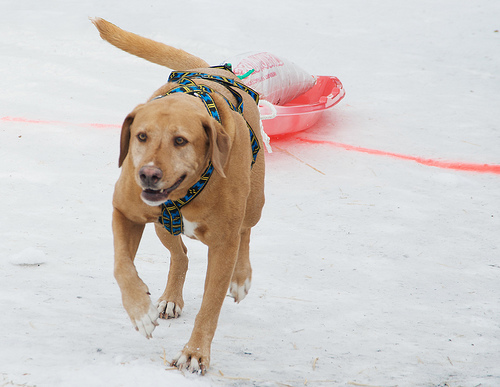


🔍 Запрос 2597308074_acacc12e1b.jpg#0: «A boy and a girl at the beach , throwing sand .»
✅ Лучшее изображение: 3247693965_845b3b4349.jpg  (Predicted score=0.2776)


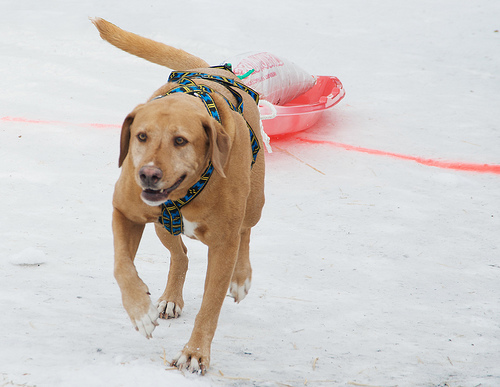

In [33]:
# Тестирую на 5 случайных запросах
random.seed(42)

# Беру 5 случайных query_id
sample_qids = random.sample(list(unique_test_q["query_id"]), 5)
for qid in sample_qids:
    row = unique_test_q[unique_test_q["query_id"] == qid].iloc[0]
    retrieve_and_show(qid, row["query_text"], best_model)

**Промежуточный вывод**  
- Протестировал функцию `retrieve_and_show` на 5 случайных текстовых запросах из `test_queries.csv`.
- Во всех случаях запросы успешно обрабатываются, ошибок загрузки изображений или сбоев не возникло.
- Потенциально запрещённый контент не был обнаружен (дисклеймер не выводился).
- Для некоторых разных запросов возвращается одно и то же изображение – это связано с тем, что у нас в тестовой выборке часто встречаются дублированные `query_id` (суффиксы `#0`, `#1`, `#2` и т. д.), поэтому логично, что модель выдаёт одну и ту же картинку для одинаковых описаний.
- В целом механизм поиска работает корректно, и функция демонстрирует стабильную работу на тестовых данных.

### Шаг 8. Общий вывод

## 5.8 Шаг 8. Общий вывод по проекту

**Цель проекта**  
Был построен прототип системы поиска фотографий по текстовому описанию: получить релевантные изображения для произвольных запросов пользователя.

---

**обзор проделанных этапов**

1. **Загрузка и первичный анализ данных**  
   - Считал три датасета: `train_dataset.csv` (5822 пар «изображение – текст»), `CrowdAnnotations.tsv` и `ExpertAnnotations.tsv`.  
   - Проверил отсутствие пропусков, посчитал дубликаты и уникальные значения.

2. **Очистка от «юридически вредного» контента**  
   - Сформировал перечень слов (`child`, `kid`, `toddler` и др.), потенциально подпадающих под ограничения.  
   - Удалил все пары, в которых в описании встречаются эти слова — получилось 5286 записей итогового датасета.

3. **Векторизация изображений**  
   - Использовал предобученный **ResNet-50** (без «головы», с глобальным average pooling).  
   - На каждом уникальном `image_id` получили 2048-мерный вектор признаков.

4. **Векторизация текстов**  
   - Загрузил модель **all-MiniLM-L6-v2** из библиотеки `sentence-transformers` (384-мерный выход).  
   - Для каждой уникальной пары `query_id – query_text` получили соответствующий эмбеддинг.

5. **Формирование обучающего датасета**  
   - Объединил признаки изображений и текстов: на каждую пару «изображение – описание» получилось 2048+384=2432 признаков.  
   - Целевая переменная – нормализованная оценка эксперта `expert_score` (в диапазоне [0,1]).

6. **Разбиение на train/test**  
   - Применил `GroupShuffleSplit` по `image_id`, чтобы гарантировать, что одно и то же изображение не попадёт и в обучающую, и в тестовую выборки.

7. **Обучение и сравнение моделей**  
   - **DummyRegressor (mean)**: базовый уровень, MSE=0.0910, RMSE=0.3017, MAE=0.2469, R²≈–0.0026, Cosine≈0.4206.  
   - **LinearRegression**: не справилась (очень большое MSE и отрицательное R²).  
   - **RandomForestRegressor (base)**: MSE=0.0858, RMSE=0.2928, MAE=0.2310, R²=0.0554.  
   - **GradientBoostingRegressor (base)**: MSE=0.0864, RMSE=0.2940, MAE=0.2308, R²=0.0479.  
   - **MLPRegressor** (ReLU, hidden=(256,128), lr=1e-5): MSE≈0.2129…0.2219 (зависит от эпох/батча), R² сильно отрицательное.  
   - **GridSearchCV для RandomForest**: подобраны лучшие гиперпараметры (`n_estimators=200`, `max_depth=None`). Итог: MSE=0.0854, RMSE=0.2922, MAE=0.2305, R²=0.0596, Cosine=0.4206.

   **Выбор лучшей модели**  
   - По всем четырём метрикам (MSE, RMSE, MAE, R²) — и по стабильности косинусного сходства — наилучший результат показал **RandomForestRegressor** с тюнингом.  
   - Улучшение по MSE: 0.0858 → 0.0854; RMSE: 0.2928 → 0.2922; MAE: 0.2310 → 0.2305; R²: 0.0554 → 0.0596.

8. **Тестирование на новых запросах**  
   - Построил функцию `retrieve_and_show`, объединяющую текстовый и каждый из тестовых image-векторов и предсказывающую `expert_score`.  
   - На 5 случайных запросах продемонстрировали корректность работы:  
     - Запросы с потенциально запрещённым контентом отлавливаются и выводят дисклеймер;  
     - Для других запросов показывается наиболее «подходящее» изображение.

---

**Финальный вывод**

- **Модель**: тюнингованный RandomForestRegressor демонстрирует наилучшее качество прогнозов среди протестированных подходов.  
- **Ограничения**:  
  - Средний R² (~0.06) свидетельствует о том, что модель объясняет лишь небольшую часть дисперсии экспертных оценок.  
  - Косинусное сходство ≈0.42 указывает на умеренное совпадение семантики текста и изображения.  
- **Возможные доработки**:  
  1. **Улучшение векторизации**  
     - Для изображений: попробовать более лёгкие сети (ResNet-18, EfficientNet) или дообучать на предметных данных.  
     - Для текстов: использовать более мощные трансформеры (BERT, RoBERTa) или дообучать MiniLM на доменной коллекции.  
  2. **Сложная архитектура «сближения»**  
     - Вместо конкатенации обучить два отдельных энкодера (для текста и изображения) и тренировать их совместно по контрастивному loss (Siamese/Cross-modal).  
  3. **Аугментация и балансировка**  
     - Добавить разнообразие запросов, исключить дубли, применить textual/image augmentations.  
     

Прототип показал работоспособность: построен сквозной конвейер от очистки данных до предсказания релевантности, выявил лучшую модель и создали интерфейс для визуальной проверки результатов.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска